# Cvxpylayers + Neuromancer


This example demonstrates integration of Cvxpylayers into Neuromancer.
We will demonstrate this capability on learning to optimize
for [parametric nonlinear programming problem (pNLP)](https://en.wikipedia.org/wiki/Parametric_programming) defined as:

$$
\begin{align}
&\text{minimize } &&  f(x, \theta) \\
&\text{subject to} && g(x, \theta) \le 0
\end{align}
$$

with  parameters $\theta$ and decision variables $x$.


### Cvxpy Layes References
[1] [Agrawal, A. and Amos, B. and Barratt, S. and Boyd, S. and Diamond, S. and Kolter, Z., Differentiable Convex Optimization Layers, NeurIPS 2019](https://arxiv.org/abs/1910.12430)  
[2] https://github.com/cvxgrp/cvxpylayers/tree/master  
[3] https://locuslab.github.io/2019-10-28-cvxpylayers/  

### Learning to Optimize References
[1] [F. Fioretto, et al., Predicting AC Optimal Power Flows: Combining Deep Learning and Lagrangian Dual Methods, 2019](https://arxiv.org/abs/1909.10461)  
[2] [S. Gould, et al., Deep Declarative Networks: A New Hope, 2020](https://arxiv.org/abs/1909.04866)  
[3] [P. Donti, et al., DC3: A learning method for optimization with hard constraints, 2021](https://arxiv.org/abs/2104.12225)  
[4] [J. Kotary, et al., End-to-End Constrained Optimization Learning: A Survey, 2021](https://arxiv.org/abs/2103.16378)  
[5] [M. Li, et al., Learning to Solve Optimization Problems with Hard Linear Constraints, 2022](https://arxiv.org/abs/2208.10611)  
[6] [R. Sambharya, et al., End-to-End Learning to Warm-Start for Real-Time Quadratic Optimization, 2022](https://arxiv.org/abs/2212.08260)  
[7] [Parametric programming in Neuromancer](https://github.com/pnnl/neuromancer/tree/master/examples/parametric_programming)

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"

### Import

In [1]:
import torch
import torch.nn as nn
import numpy as np
import cvxpy
from cvxpylayers.torch import CvxpyLayer

# plotting
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

# neuromancer
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.system import Node

# Problem Formulation

Specifically we will focus on solving the [Rosenbrock problem](https://en.wikipedia.org/wiki/Rosenbrock_function):

$$
\begin{align}
&\text{minimize } &&  (1-x_1)^2 + p(x_2-x_1^2)^2\\
&\text{subject to} && Ax \le b
\end{align}
$$

with parameters $p, b$ and decision variables $x= [x_1, x_2]$.

In this tutorial, we will use neuromancer to train the neural network to minimize the nonlinear objective function,
and cvxpy layers to project the solution onto feasible region.

In [2]:
nx = 2              #  number of decision variables
n_con = 4           #  number of constraints
n_p = 1             #  number of objective parameters

# generate fixed parameters of the inequality constraints: Ax <= b
torch.manual_seed(7)
A = torch.FloatTensor(n_con, nx).uniform_(-4, 4)
x0 = torch.full([nx], 0.5)       # controls center of the polytope
s0 = torch.full([n_con], 0.2)    # controls offset from the center of the polytope
b0 = A.mv(x0) + s0

## Dataset

We constructy the dataset by sampling the parametric space.

In [3]:
data_seed = 408  # random seed used for simulated data
np.random.seed(data_seed)
torch.manual_seed(data_seed);

Randomly sample parameters from a uniform distribution: $0.5\le p\le2.0$;  $0.2\le a\le1.2$

In [4]:
nsim = 1000  # number of datapoints: increase sample density for more robust results
# create dictionaries with sampled datapoints with uniform distribution
p_low, p_high = 0.2, 5.0,
b_low, b_high = 0.0, 1.0,
# we sample objective and constraints parameters
samples_train = {"p": torch.FloatTensor(nsim, n_p).uniform_(p_low, p_high),
                 "b_param": torch.FloatTensor(nsim, n_con).uniform_(b_low, b_high)}
samples_dev = {"p": torch.FloatTensor(nsim, n_p).uniform_(p_low, p_high),
               "b_param": torch.FloatTensor(nsim, n_con).uniform_(b_low, b_high)}
samples_test = {"p": torch.FloatTensor(nsim, n_p).uniform_(p_low, p_high),
                "b_param": torch.FloatTensor(nsim, n_con).uniform_(b_low, b_high)}
# create named dictionary datasets
train_data = DictDataset(samples_train, name='train')
dev_data = DictDataset(samples_dev, name='dev')
test_data = DictDataset(samples_test, name='test')
# create torch dataloaders for the Trainer
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0,
                                           collate_fn=train_data.collate_fn, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=32, num_workers=0,
                                         collate_fn=dev_data.collate_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, num_workers=0,
                                         collate_fn=test_data.collate_fn, shuffle=True)
# note: training quality will depend on the DataLoader parameters such as batch size and shuffle

## Primal Solution Map Architecture

A neural network mapping problem parameters onto primal decision variables:  
$$x = \pi(\theta)$$

In [5]:
# define neural architecture for the trainable solution map
# mapping problem parameters to decitionv ariables
func = blocks.MLP(insize=n_con+n_p, outsize=nx,
                bias=True,
                linear_map=torch.nn.Linear,
                nonlin=nn.ReLU,
                hsizes=[80] * 4)
# wrap neural net into symbolic representation of the solution map via the Node class:
# sol_map(p, bparam) -> xy
sol_map = Node(func, ['p', 'b_param'], ['x'], name='map')

## Objective in NeuroMANCER


We want to minimize the objective:
$$
\begin{align}
&\text{minimize } &&  (1-x_1)^2 + p(x_2-x_1^2)^2
\end{align}
$$

with $x = [x_1, x_2]$ being decision variables and $p$ being problem parameter.

In [6]:
# define decision variables
x1 = variable("x")[:, [0]]
x2 = variable("x")[:, [1]]
# problem parameters sampled in the dataset
p = variable('p')
b_param = variable('b_param')

# objective function
f = (1-x1)**2 + p*(x2-x1**2)**2
nm_obj = f.minimize(weight=10.0, name='obj')

## Cvxpy projection layer

We will use cvxpy layer to implement the projection onto the polytopic constraints:

$$
\begin{align}
& \hat{x}  = \text{argmin}_x && ||x -  \hat{x}  ||_2^2 \\
&\text{subject to} && A \hat{x} \le b
\end{align}
$$

with $x$ being solution obtained from the neural network $x = \pi(\theta)$, and $\hat{x}$ being projected solution onto the feasible set satisfying $A \hat{x} \le b$. Here the problem constraints are parametrized by $b$ and solution from neural network $x$. Hence we can compactly represent this projection operator as:  

$$\hat{x} = \text{proj}_{A x \le b}(x, b) $$

Cvxpy layers allow us to use this projection operator as a differentiable layer in our end-to-end solver pipeline.


<img src="./figs/cvxpylayers_overview.png" width="600">  

In [7]:
# constants, parameters, and variables
A_cvxpy = A.detach().numpy()
b0_cvxpy = b0.detach().numpy()
b_cvxpy = cvxpy.Parameter(n_con)
xy_net = cvxpy.Parameter(nx)      # primal decision from neural net
xy_cvxpy = cvxpy.Variable(nx)     # cvxpy decision variable

# projection problem formulation
cvxpy_obj = cvxpy.Minimize(1.0 * cvxpy.sum_squares(xy_net - xy_cvxpy))
cvxpy_cons = [xy_cvxpy@A_cvxpy.T <= b0_cvxpy + b_cvxpy]
cvxpy_prob = cvxpy.Problem(cvxpy_obj, cvxpy_cons)

# cvxpy layer
cvxpy_layer = CvxpyLayer(cvxpy_prob,
                   parameters=[b_cvxpy, xy_net],
                   variables=[xy_cvxpy])

# symbolic wrapper: sol_map(bparam, xy) -> xy
project = Node(cvxpy_layer, ['b_param', 'xy'], ['xy_cvx'], name='proj')

## Self-supervised loss

We can use the correction form the cvxpylayer as a supervisory signal for the neural network alongside with the objective minimization loss function term. This extra term can be used as a guide for the neural network to satisfy constraints of the problem by following the projected solution. The larger the weigthing factor of this loss function term the closer the neural network will be to feasible region on its own without the subsequent projection.

In [8]:
# corrected variable by the cvxpy layer
xy_cvx = variable("xy_cvx")
# cvxpy-supervised loss for the neural net
residual = torch.abs(xy - xy_cvx)
cvxp_loss = 1.*(residual == 0)

## Construct differentiable parametric optimization problem 

Here we put all the pieces together and construct differentiable parametric constrained optimization problem with neural network and cvxpy projection layer as solvers.

In [15]:
# constrained optimization problem construction
objectives = [nm_obj, cvxp_loss]
constraints = []
nodes = [sol_map, project]

# create penalty method loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(nodes, loss)
# plot computational graph
# problem.show()

## Parametric Problem Solution in NeuroMANCER

Here we will use stochastic gradient descent to optimize the neural network $x = \pi({\theta})$ to solve a distribution of sampled problem instances.

In [10]:
lr = 0.001      # step size for gradient descent
epochs = 10    # number of training epochs
warmup = 10    # number of epochs to wait before enacting early stopping policy
patience = 10  # number of epochs with no improvement in eval metric to allow before early stopping

In [11]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=lr)
# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=epochs,
    patience=patience,
    warmup=warmup,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric="dev_loss",
)

In [12]:
# Train NLP solution map
best_model = trainer.train()
best_outputs = trainer.test(best_model)
# load best model dict
problem.load_state_dict(best_model)

C:\Users\drgo694\OneDrive - PNNL\Documents\anaconda3\envs\neuromancer\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
C:\Users\drgo694\OneDrive - PNNL\Documents\Codes_dev\neuromancer\neuromancer\src\neuromancer\constraint.py:160: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([32, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)
C:\Users\drgo694\OneDrive - PNNL\Documents\Codes_dev\neuromancer\neuro

epoch: 0  train_loss: 3.2589502334594727
epoch: 1  train_loss: 0.3854717016220093
epoch: 2  train_loss: 0.2311873733997345
epoch: 3  train_loss: 0.19490069150924683
epoch: 4  train_loss: 0.18166537582874298
epoch: 5  train_loss: 0.17738522589206696
epoch: 6  train_loss: 0.17531147599220276
epoch: 7  train_loss: 0.1747892051935196
epoch: 8  train_loss: 0.17444591224193573
epoch: 9  train_loss: 0.17344164848327637


<All keys matched successfully>

## Plot the solution

In [16]:
def plot_pNLP(p, b_param, savedir=None):
    # sample primal solution domain
    x1 = np.arange(-0.5, 1.5, 0.02)
    y1 = np.arange(-0.5, 1.5, 0.02)
    xx, yy = np.meshgrid(x1, y1)
    xy_samples = np.stack([xx.flatten(), yy.flatten()])

    # eval constraints Ax - b <= 0
    A_np = A.detach().numpy()
    b = b0 + b_param
    b_np = b.detach().numpy()
    C_samples = np.subtract(np.matmul(A_np, xy_samples).T, b_np).T
    C_samples = C_samples.reshape(n_con, x1.shape[0], y1.shape[0])

    # eval objective
    p_np = p.detach().numpy()
    J = (1 - xx) ** 2 + p_np * (yy - xx ** 2) ** 2

    # plot objective and constraints
    fig, ax = plt.subplots(1, 1)
    cp = ax.contourf(xx, yy, J,
                     levels=[0, 0.05, 0.2, 0.5, 1.0, 2.0, 4.0, 6.0, 8.0, 16],
                     alpha=0.6)
    fig.colorbar(cp)
    ax.set_title('Rosenbrock problem')
    for k in range(n_con):
        cg1 = ax.contour(xx, yy, -C_samples[k], [0],
                         colors='mediumblue', alpha=0.7)
        plt.setp(cg1.collections,
                 path_effects=[patheffects.withTickedStroke()], alpha=0.7)

    # Solution to pNLP via Neuromancer
    datapoint = {'p': p, 'b_param': b_param,
                 'name': 'test'}
    # evaluate neuromancer model
    model_out = problem.step(datapoint)
    # neural net solution
    x_nm_net = model_out["xy"][0].detach().numpy()
    y_nm_net = model_out["xy"][1].detach().numpy()
    # cvxpy projected solution
    x_nm_cvx = model_out["xy_cvx"][0].detach().numpy()
    y_nm_cvx = model_out["xy_cvx"][1].detach().numpy()

    # plot optimal solutions CasADi vs Neuromancer
    ax.plot(x_nm_net, y_nm_net, 'r*', fillstyle='none',
            markersize=16, label='net')
    ax.plot(x_nm_cvx, y_nm_cvx, 'g*', fillstyle='none',
            markersize=14, label='cvxpy')
    # plot projection step
    ax.plot([x_nm_net, x_nm_cvx],
            [y_nm_net, y_nm_cvx], '--', c='orange')
    plt.legend(bbox_to_anchor=(1.0, 0.15))

    if savedir is not None:
        if not os.path.exists(savedir):
            os.mkdir(savedir)
        figure_path = os.path.join(savedir, f'pNLP_p={p}_bsum={b_np}.png')
        plt.savefig(figure_path)
        return figure_path
    else:
        plt.show(block=True)


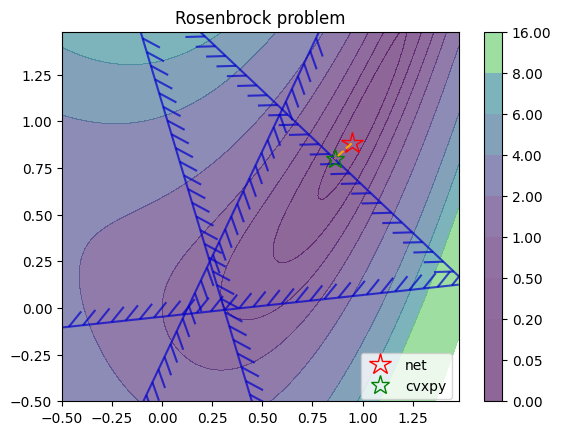

In [18]:
# sample random scenario
p = torch.FloatTensor(n_p).uniform_(p_low, p_high)
b_param = torch.rand(n_con)
# plot single random scenario
plot_pNLP(p, b_param)